In [103]:
import numpy as np
import streamlit as st
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 

st.set_page_config(page_title="Mobile Pricing Decision Boundary", layout="wide")

2025-05-21 15:54:12.169 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.


## Prepairing the Sample

In [104]:
smartphones = pd.read_json("smartphonesSpecs.json") # 
smartphones.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        54 non-null     object
 1   img         54 non-null     object
 2   detailSpec  54 non-null     object
 3   quickSpec   54 non-null     object
dtypes: object(4)
memory usage: 1.8+ KB


In [105]:
# helper functions
import re
def extract_antutu(s: str) -> int | None:
    """
    Searches for 'AnTuTu:' in the string and returns the following integer,
    or None if no match is found—or if the input isn't even a string.
    """
    if not isinstance(s, str):
        return None
    m = re.search(r'AnTuTu:\s*([\d,]+)', s)
    if not m:
        return None
    num_str = m.group(1).replace(",", "")
    return int(num_str)

def get_spec(exists_in: str, original_name: str, view_name: str):
    """
    Find the in the detailed specification in the smartphones sample
    return it as a pandas data series, labeled as view_name
    """ 
    return (
    smartphones["detailSpec"]
    .apply(
        lambda specs: {
            d["category"]: (
                next(
                        (spec["value"] for spec in d["specifications"] if spec["name"] == original_name),
                        None,
                    )
            )
            for d in specs
            if d["category"] == exists_in
        }
    )
    .apply(pd.Series)
)[exists_in].rename(view_name)

In [106]:
# Extract the quickSpec into the shape: (specName: $value)
quick_specs_dicts = smartphones["quickSpec"].apply(
    lambda specs: {d["name"]: d["value"] for d in specs}
)

specs_numeric = pd.concat(
    [
        smartphones["name"],
        quick_specs_dicts.apply(pd.Series),  # each dict becomes columns
        get_spec(exists_in="Tests", original_name="Performance", view_name="performanceScore"),
        get_spec(exists_in="Misc", original_name="Price", view_name="price"),
        get_spec(exists_in="Memory", original_name="Internal", view_name="storage"),
        get_spec(exists_in="Display", original_name="Resolution", view_name="ppi"),
        get_spec(exists_in="Display", original_name="Type", view_name="refreshRate"),
    ],
    axis=1,
)

# SHAPING
specs_numeric["performanceScore"] =(
    specs_numeric["performanceScore"]
      .map(extract_antutu)        
      .astype(float)
)
specs_numeric["Battery size"] = (
    specs_numeric["Battery size"]
      .str.extract(r'(\d+)')[0]
      .astype(int)                
)
specs_numeric["Camera pixels"] = (
    specs_numeric["Camera pixels"]
      .str.extract(r'(\d+)')[0]
      .astype(int)                
)
specs_numeric["Video pixels"] = (
    specs_numeric["Video pixels"]
      .str.extract(r'(\d+)')[0]
      .astype(int)                
)
pricePattern = (
    r'(?:€\s*|About\s*)'        
    r'([\d,]+(?:\.\d+)?)'       
    r'(?=\s*EUR)?'              
)
specs_numeric["price"] = (
    specs_numeric["price"]
      .str.extract(pricePattern, expand=False)     
      .str.replace(',', '', regex=False)         
      .astype(float)                            
)
storagePattern = r'^(\d+)(?=GB)'
specs_numeric["storage"] = (
    specs_numeric["storage"]
      .str.extract(storagePattern, expand=False)     
      .astype(float)                            
)
ppiPattern = r'(\d+) (?=\s*ppi)'
specs_numeric["ppi"] = (
    specs_numeric["ppi"]
      .str.extract(ppiPattern, expand=False)     
      .astype(float)                            
)
refreshRatePattern = r'(\d+)(?=Hz)'
specs_numeric["refreshRate"] = (
    specs_numeric["refreshRate"]
      .str.extract(refreshRatePattern, expand=False)     
      .astype(float)                            
)

# pruning
specs_numeric = specs_numeric.drop(columns=["Battery type", "Display size", "Chipset", "RAM size", "Display resolution"])
specs_numeric = specs_numeric.loc[(specs_numeric["performanceScore"].notnull()) 
                      & (specs_numeric["refreshRate"].notnull())
                      ]

# Formating
pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
specs_numeric = specs_numeric.set_index(specs_numeric["name"])
specs_numeric = specs_numeric.drop(columns="name")

specs_numeric.head()

,Camera pixels,Video pixels,Battery size,performanceScore,price,storage,ppi,refreshRate
name,,,,,,,,
Xiaomi Redmi 13,108,1080,5030,"258,090.00",98.32,128.00,396.00,90.00
Nothing Phone (3a) Pro,50,2160,5000,"820,097.00",455.00,128.00,387.00,120.00
Nothing Phone (3a),50,2160,5000,"828,429.00",327.90,128.00,387.00,120.00
Xiaomi 15,50,4320,5240,"2,534,638.00",793.00,256.00,460.00,120.00
Xiaomi Poco F7 Ultra,50,4320,5300,"2,580,520.00",699.90,256.00,526.00,120.00


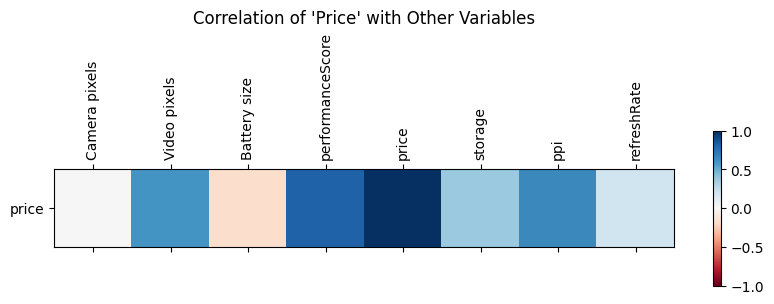

price               1.00
performanceScore    0.81
ppi                 0.64
Video pixels        0.60
storage             0.37
refreshRate         0.20
Camera pixels       0.01
Battery size       -0.18
Name: price, dtype: float64

In [107]:
# Finding the correlation Between the price and other features
corr = specs_numeric.corr()
price_corr = corr.loc[['price']]  
fig = plt.figure(figsize=(10, 2))
plt.matshow(price_corr, cmap='RdBu', fignum=fig.number, vmin=-1, vmax=1)
plt.xticks(range(len(price_corr.columns)), price_corr.columns, rotation=90)
plt.yticks([0], price_corr.index)
plt.title("Correlation of 'Price' with Other Variables")
plt.colorbar()
plt.show()
corr.loc["price"].sort_values(ascending=False)

In [108]:
specs_numeric["score_per_euro"] = specs_numeric["performanceScore"] /  specs_numeric["price"]
X = specs_numeric[["performanceScore", "price"]].to_numpy()
avg_spd = specs_numeric["score_per_euro"].median()
y = (specs_numeric["score_per_euro"] >= avg_spd).astype(int).tolist()

## Training the Classifier


In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.utils import shuffle
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(
    [
        ("poly", PolynomialFeatures(degree=2)),
        ("scale", StandardScaler()),
        ("logreg", LogisticRegression()),  
    ]
)
mod = GridSearchCV(
    estimator=pipe, 
    param_grid={},
    cv=3,
)
X_shuffled, y_shuffled = shuffle(X, y, random_state=42)
mod.fit(X_shuffled, y_shuffled)
pd.DataFrame(mod.cv_results_).to_csv(
    "cv_results.csv", index=False
) 

## Visualizing Decision Boundaries with Confidence Intesity


In [110]:
x_min, x_max = X[:, 0].min() - 50000, X[:, 0].max() + 50000
y_min, y_max = X[:, 1].min() - 50, X[:, 1].max() + 50
nx, ny = 200, 200
x_vals = np.linspace(x_min, x_max, nx)
y_vals = np.linspace(y_min, y_max, ny)
xx, yy = np.meshgrid(x_vals, y_vals)

In [111]:
probs = mod.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
probs = probs.reshape(xx.shape)

In [112]:
# Create heatmap (probability background)
import plotly.graph_objects as go

red   = "#E74C3C" 
green = "#2ECC71"
heatmap = go.Contour(
    x=x_vals,
    y=y_vals,
    z=probs,
    colorscale=[(0, red), (1, green)],
    opacity=0.8,
    colorbar=dict(
        title="Underpriced Probability",
        x=1.1,
    ),
)

In [113]:
# Add scatter plot (the actual sample points)
smartphoneNames = specs_numeric.index
scatter = go.Scatter(
    x=X[:, 0],
    y=X[:, 1],
    mode="markers",
    marker=dict(
        size=8,
        color=y,
        colorscale= [red, green],
        line=dict(width=1, color="black"),
    ),
    name="Smartphones",
    text=[f"Label: {label}" for label in y],
    customdata=smartphoneNames,
    hovertemplate=(
        "Name: %{customdata}<br>"
        "Performance: %{x}<br>"
        "Price: $%{y}<extra></extra>"
    ),
)

In [114]:
from IPython.display import HTML

fig = go.Figure(data=[
    heatmap, 
    scatter,
    ])
fig.update_layout(
    title="Price Intensity Based on Mobile Performance",
    xaxis_title="Performance Score",
    yaxis_title="Starting Price in Euro",
    width=800,
    height=600,
)

# st.plotly_chart(fig, use_container_width=True)
html = fig.to_html(include_plotlyjs="cdn")
HTML(html)